# Lead Close Rate Classification Model

In [84]:
import numpy as np
import pandas as pd

## Import Raw Data

In [85]:
# report contains all quotes and orders data in 2017
report = pd.read_csv('../report1701-1708.csv', na_values=['','null','Not quoted yet','NA','<NA>','No'], encoding='latin-1')
# enrich contains all correctly enriched customer information from Clearbit and Orb
enrich = pd.read_csv('full_enriched_customer.csv', na_values=['','NA'], encoding='latin-1')

## Data Cleaning

In [86]:
full = pd.merge(report, enrich, on='Customer.No', how='left')
full['Request.Date'] = pd.to_datetime(full['Request.Date'],format='%Y-%m-%d %H:%M:%S')
full['Invoice.Accept.Date'] = full['Invoice.Accept.Date'].fillna('2100-01-01 00:00:00')
full['Invoice.Accept.Date'] = pd.to_datetime(full['Invoice.Accept.Date'],format='%Y-%m-%d %H:%M:%S')
full['Order.Number'].replace("[^0-9]+$","",inplace=True,regex=True)
full['Order.Number'] = full['Order.Number'].fillna('no_order')
full['Product'].replace("^Custom ","",inplace=True,regex=True)
full['Paid.Amount'] = full['Paid.Amount'].fillna(0)
full[['industry_category','industry_sub_category','range_employees','range_revenue']] = full[['industry_category','industry_sub_category','range_employees','range_revenue']].fillna('personal')
# add flags whether first quote
full = full[full['Quote.No'].notnull()]
full = full.sort_values(['Request.Date','Invoice.Accept.Date'])
# change definition of new quote to quotes before first order
full['paid_amt_lag'] = full.groupby('Customer.No')['Paid.Amount'].shift(1).fillna(0)
full['whether_new'] = np.where((full['Customer.No'].duplicated())&(~(full['paid_amt_lag']==0)),0,1)
full = full[['Quote.No','Request.Date','Invoice.Accept.Date','Product','Order.Number','Customer.No','Paid.Amount','industry_category','industry_sub_category','range_employees','range_revenue','whether_new','Sales.Rep']]
grouped_amt = full[['Quote.No','Order.Number','Paid.Amount']].copy()
grouped_amt = grouped_amt.groupby(['Quote.No','Order.Number']).sum().reset_index()
full = full[(~full[['Order.Number']].duplicated())|(full['Order.Number']=='no_order')]
full = pd.merge(full[full.columns.difference(['Paid.Amount'])], grouped_amt, on=['Quote.No','Order.Number'], how='left')

## Building Expert Variables

In [87]:
# add sales cycle and flags whether the quote is closed within 3 days and 2 weeks
full['close_3d'] = np.where((full['Invoice.Accept.Date']-full['Request.Date']).apply(lambda x: x.days)<4, 1, 0)
full['close_2w'] = np.where((full['Invoice.Accept.Date']-full['Request.Date']).apply(lambda x: x.days)<15, 1, 0)
full['whether_order'] = np.where(full['Paid.Amount']==0,0,1)
full['sales_cycle'] = (full['Invoice.Accept.Date']-full['Request.Date']).apply(lambda x: x.days) * full['whether_order']

# calculate the historical aov, average close rate, average sales cycle
full['ones'] = 1
full.ix[0, 'ones'] = 0
full['amt_lag'] = full['Paid.Amount'].shift(1).fillna(0)
full['whether_order_lag'] = full['whether_order'].shift(1).fillna(0)
full['sales_cycle_lag'] = full['sales_cycle'].shift(1).fillna(0)

full['aov'] = (full['amt_lag'].cumsum()/full['whether_order_lag'].cumsum()).fillna(0)
full['avg_close_rate'] = (full['whether_order_lag'].cumsum()/full['ones'].cumsum()).fillna(0)
full['avg_sales_cycle'] = (full['sales_cycle_lag'].cumsum()/full['whether_order_lag'].cumsum()).fillna(0)

# calculate the number of quotes since last order
full['order_grp'] = full.groupby('Customer.No')['whether_order'].cumsum()
full['quotes_since'] = full.groupby(['Customer.No','order_grp']).cumcount()
full['quotes_since_last_order'] = np.where(full['order_grp']==0,full['quotes_since']+1,full['quotes_since'])
full['quotes_since_last_order'] = np.where(full['whether_order']==1,full.groupby('Customer.No')['quotes_since_last_order'].shift(1).fillna(0)+1,full['quotes_since_last_order'])

# add the lag1 columns for paid.amount, whether_order, sales_cycle for each category
full['product_amt_lag'] = full.groupby('Product')['Paid.Amount'].shift(1).fillna(0)
full['industry_category_amt_lag'] = full.groupby('industry_category')['Paid.Amount'].shift(1).fillna(0)
full['industry_sub_category_amt_lag'] = full.groupby('industry_sub_category')['Paid.Amount'].shift(1).fillna(0)
full['range_employees_amt_lag'] = full.groupby('range_employees')['Paid.Amount'].shift(1).fillna(0)
full['range_revenue_amt_lag'] = full.groupby('range_revenue')['Paid.Amount'].shift(1).fillna(0)

full['product_order_lag'] = full.groupby('Product')['whether_order'].shift(1).fillna(0)
full['industry_category_order_lag'] = full.groupby('industry_category')['whether_order'].shift(1).fillna(0)
full['industry_sub_category_order_lag'] = full.groupby('industry_sub_category')['whether_order'].shift(1).fillna(0)
full['range_employees_order_lag'] = full.groupby('range_employees')['whether_order'].shift(1).fillna(0)
full['range_revenue_order_lag'] = full.groupby('range_revenue')['whether_order'].shift(1).fillna(0)

full['product_sc_lag'] = full.groupby('Product')['sales_cycle'].shift(1).fillna(0)
full['industry_category_sc_lag'] = full.groupby('industry_category')['sales_cycle'].shift(1).fillna(0)
full['industry_sub_category_sc_lag'] = full.groupby('industry_sub_category')['sales_cycle'].shift(1).fillna(0)
full['range_employees_sc_lag'] = full.groupby('range_employees')['sales_cycle'].shift(1).fillna(0)
full['range_revenue_sc_lag'] = full.groupby('range_revenue')['sales_cycle'].shift(1).fillna(0)

# calculate AOV by product, industry_category, industry_sub_category, range_employee, range_revenue based on lag1 values
full['product_aov'] = (full.groupby('Product')['product_amt_lag'].cumsum()/full.groupby('Product')['product_order_lag'].cumsum()).fillna(0)
full['industry_category_aov'] = (full.groupby('industry_category')['industry_category_amt_lag'].cumsum()/full.groupby('industry_category')['industry_category_order_lag'].cumsum()).fillna(0)
full['industry_sub_category_aov'] = (full.groupby('industry_sub_category')['industry_sub_category_amt_lag'].cumsum()/full.groupby('industry_sub_category')['industry_sub_category_order_lag'].cumsum()).fillna(0)
full['range_employees_aov'] = (full.groupby('range_employees')['range_employees_amt_lag'].cumsum()/full.groupby('range_employees')['range_employees_order_lag'].cumsum()).fillna(0)
full['range_revenue_aov'] = (full.groupby('range_revenue')['range_revenue_amt_lag'].cumsum()/full.groupby('range_revenue')['range_revenue_order_lag'].cumsum()).fillna(0)

# calculate historical close rate and average sales cycle 
# by product, industry_category, industry_sub_category, range_employee, range_revenue based on lag1 values
full['product_close_rate'] = (full.groupby('Product')['product_order_lag'].cumsum()/full.groupby('Product').cumcount()).fillna(0)
full['product_asc'] = (full.groupby('Product')['product_sc_lag'].cumsum()/full.groupby('Product')['product_order_lag'].cumsum()).fillna(0)
full['industry_category_close_rate'] = (full.groupby('industry_category')['industry_category_order_lag'].cumsum()/full.groupby('industry_category').cumcount()).fillna(0)
full['industry_category_asc'] = (full.groupby('industry_category')['industry_category_sc_lag'].cumsum()/full.groupby('industry_category')['industry_category_order_lag'].cumsum()).fillna(0)
full['industry_sub_category_close_rate'] = (full.groupby('industry_sub_category')['industry_sub_category_order_lag'].cumsum()/full.groupby('industry_sub_category').cumcount()).fillna(0)
full['industry_sub_category_asc'] = (full.groupby('industry_sub_category')['industry_sub_category_sc_lag'].cumsum()/full.groupby('industry_sub_category')['industry_sub_category_order_lag'].cumsum()).fillna(0)
full['range_employees_close_rate'] = (full.groupby('range_employees')['range_employees_order_lag'].cumsum()/full.groupby('range_employees').cumcount()).fillna(0)
full['range_employees_asc'] = (full.groupby('range_employees')['range_employees_sc_lag'].cumsum()/full.groupby('range_employees')['range_employees_order_lag'].cumsum()).fillna(0)
full['range_revenue_close_rate'] = (full.groupby('range_revenue')['range_revenue_order_lag'].cumsum()/full.groupby('range_revenue').cumcount()).fillna(0)
full['range_revenue_asc'] = (full.groupby('range_revenue')['range_revenue_sc_lag'].cumsum()/full.groupby('range_revenue')['range_revenue_order_lag'].cumsum()).fillna(0)

# calculate customer total spend, total orders, AOV, average close rate, average sales cycle
full['cust_amt_lag'] = full.groupby('Customer.No')['Paid.Amount'].shift(1).fillna(0)
full['cust_order_lag'] = full.groupby('Customer.No')['whether_order'].shift(1).fillna(0)
full['cust_sc_lag'] = full.groupby('Customer.No')['sales_cycle'].shift(1).fillna(0)

full['cust_tot_spend'] = full.groupby('Customer.No')['cust_amt_lag'].cumsum()
full['cust_tot_orders'] = full.groupby('Customer.No')['cust_order_lag'].cumsum()
full['cust_aov'] = (full['cust_tot_spend']/full['cust_tot_orders']).fillna(0)
full['cust_close_rate'] = (full['cust_tot_orders']/full.groupby('Customer.No').cumcount()).fillna(0)
full['cust_asc'] = (full.groupby('Customer.No')['cust_sc_lag'].cumsum()/full['cust_tot_orders']).fillna(0)

# caculate AOV, average close rate, average sales cycle for new/old customer
full['whether_new_amt_lag'] = full.groupby('whether_new')['Paid.Amount'].shift(1).fillna(0)
full['whether_new_order_lag'] = full.groupby('whether_new')['whether_order'].shift(1).fillna(0)
full['whether_new_sc_lag'] = full.groupby('whether_new')['sales_cycle'].shift(1).fillna(0)

full['whether_new_aov'] = (full.groupby('whether_new')['whether_new_amt_lag'].cumsum()/full.groupby('whether_new')['whether_new_order_lag'].cumsum()).fillna(0)
full['whether_new_close_rate'] = (full.groupby('whether_new')['whether_new_order_lag'].cumsum()/full.groupby('whether_new').cumcount()).fillna(0)
full['whether_new_asc'] = (full.groupby('whether_new')['whether_new_sc_lag'].cumsum()/full.groupby('whether_new')['whether_new_order_lag'].cumsum()).fillna(0)

# caculate AOV, average close rate, average sales cycle by sales rep
full['sales_rep_amt_lag'] = full.groupby('Sales.Rep')['Paid.Amount'].shift(1).fillna(0)
full['sales_rep_order_lag'] = full.groupby('Sales.Rep')['whether_order'].shift(1).fillna(0)
full['sales_rep_sc_lag'] = full.groupby('Sales.Rep')['sales_cycle'].shift(1).fillna(0)

full['sales_rep_aov'] = (full.groupby('Sales.Rep')['sales_rep_amt_lag'].cumsum()/full.groupby('Sales.Rep')['sales_rep_order_lag'].cumsum()).fillna(0)
full['sales_rep_close_rate'] = (full.groupby('Sales.Rep')['sales_rep_order_lag'].cumsum()/full.groupby('Sales.Rep').cumcount()).fillna(0)
full['sales_rep_asc'] = (full.groupby('Sales.Rep')['sales_rep_sc_lag'].cumsum()/full.groupby('Sales.Rep')['sales_rep_order_lag'].cumsum()).fillna(0)

In [88]:
# assign the previous historical value for the missing aov, acr, asc
col_types = ['product', 'industry_category', 'industry_sub_category', 'range_employees',
             'range_revenue', 'cust', 'whether_new', 'sales_rep']
for col in col_types:
    full[col+'_aov'] = np.where(full[col+'_aov']==0, full['aov'], full[col+'_aov'])
    full[col+'_close_rate'] = np.where(full[col+'_close_rate']==0, full['avg_close_rate'], full[col+'_close_rate'])
    full[col+'_asc'] = np.where(full[col+'_asc']==0, full['avg_sales_cycle'], full[col+'_asc'])

## Loading Machine Learning Packages

In [89]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [90]:
# remove auxiliary variables
df = full[full.columns.difference(['whether_order','order_grp','quotes_since','ones'])].copy()
cols = [col for col in list(df) if not col.endswith('_lag')]
df = df[cols]
# take a look to all the fields
df.columns

Index([                     u'Customer.No',
                    u'Invoice.Accept.Date',
                           u'Order.Number',
                            u'Paid.Amount',
                                u'Product',
                               u'Quote.No',
                           u'Request.Date',
                              u'Sales.Rep',
                                    u'aov',
                         u'avg_close_rate',
                        u'avg_sales_cycle',
                               u'close_2w',
                               u'close_3d',
                               u'cust_aov',
                               u'cust_asc',
                        u'cust_close_rate',
                        u'cust_tot_orders',
                         u'cust_tot_spend',
                      u'industry_category',
                  u'industry_category_aov',
                  u'industry_category_asc',
           u'industry_category_close_rate',
                  u'industry_sub

## Preprocessing

In [91]:
# z-zcaling all features, note that we only use numeric variables as features 
df1 = df.copy()
cols = ['aov', 'avg_close_rate', 'avg_sales_cycle',
        'whether_new_aov', 'whether_new_close_rate', 'whether_new_asc',
        'cust_tot_spend','cust_tot_orders','cust_aov','cust_close_rate','cust_asc','quotes_since_last_order',
        'product_aov','product_close_rate','product_asc',
        'industry_category_aov','industry_category_close_rate','industry_category_asc',
        'industry_sub_category_aov','industry_sub_category_close_rate','industry_sub_category_asc',
        'range_employees_aov','range_employees_close_rate','range_employees_asc',
        'range_revenue_aov','range_revenue_close_rate','range_revenue_asc',
        'sales_rep_aov','sales_rep_close_rate','sales_rep_asc']

df1[cols] = scale(df1[cols])
features = df1[cols]

# here y is the flag whether the quote is closed in 3 days or 2 weeks
close_3d = df1['close_3d']
close_2w = df1['close_2w']

In [92]:
## Run this line to generate the training dataset used to test REST API
df1[['Quote.No','close_3d','close_2w']+cols].to_csv('training.csv',index=False)

In [93]:
# train-test split for close_3d. 75% as training and 25% as testing
x_train1, x_test1, y_train1, y_test1 = train_test_split(features, close_3d, test_size=0.25, random_state=31)

# train-test split for close_2w. 75% as training and 25% as testing
x_train2, x_test2, y_train2, y_test2 = train_test_split(features, close_2w, test_size=0.25, random_state=31)

# neutralize the sales rep variables
x_test1.loc[:,'sales_rep_aov'] = x_test1['aov']
x_test1.loc[:,'sales_rep_close_rate'] = x_test1['avg_close_rate']
x_test1.loc[:,'sales_rep_asc'] = x_test1['avg_sales_cycle']

x_test2.loc[:,'sales_rep_aov'] = x_test2['aov']
x_test2.loc[:,'sales_rep_close_rate'] = x_test2['avg_close_rate']
x_test2.loc[:,'sales_rep_asc'] = x_test2['avg_sales_cycle']

In [94]:
# test whether closed in 3 days for new customer only
x_test3 = x_test1[df['whether_new']==1].copy()
y_test3 = y_test1[df['whether_new']==1].copy()
x_test4 = x_test2[df['whether_new']==1].copy()
y_test4 = y_test2[df['whether_new']==1].copy()


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Modeling

#### Define functions for result reporting

In [95]:
def model_report(model, x_test, y_test, name='MLP', title='3 Days'):
    model_pred = model.predict(x_test)
    model_predprob = model.predict_proba(x_test)[:,1]
    model_accuracy = accuracy_score(y_test, model_pred)
    model_auc = roc_auc_score(y_test, model_predprob)
    model_cfm = confusion_matrix(y_test, model_pred)
    print "%s Testing Report for Whether Closed in %s:" % (name, title)
    print "%s accuracy: %.4g" % (name, model_accuracy)
    print "%s AUC Score: %.4g" % (name, model_auc)
    print "%s confusion matrix:" % name
    print "True Positive", model_cfm[1][1]
    print "True Negative", model_cfm[0][0]
    print "False Positive", model_cfm[0][1]
    print "False Negative", model_cfm[1][0]

In [96]:
def xgb_importance_plot(model):
    feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

## Classification Modeling for Whether Closed in 3 Days 

#### Multi-layer Perceptron Classifier (MLP)

In [97]:
mlp1 = MLPClassifier(hidden_layer_sizes=(31,31), activation = "logistic", random_state=31)
mlp1.fit(x_train1, y_train1)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(31, 31), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=31, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [98]:
model_report(mlp1, x_test1, y_test1)

MLP Testing Report for Whether Closed in 3 Days:
MLP accuracy: 0.9433
MLP AUC Score: 0.9699
MLP confusion matrix:
True Positive 1502
True Negative 31177
False Positive 1177
False Negative 788


#### XGBoost Classifier

In [99]:
xgb1 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=200, reg_alpha=1, reg_lambda=3, random_state=31)
xgb1.fit(x_train1, y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=31, reg_alpha=1, reg_lambda=3, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

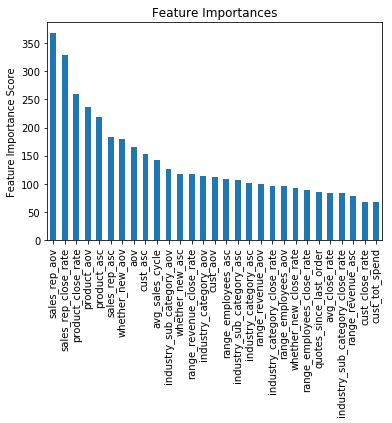

In [100]:
xgb_importance_plot(xgb1)

In [101]:
model_report(xgb1, x_test1, y_test1, name='XGB')

XGB Testing Report for Whether Closed in 3 Days:
XGB accuracy: 0.9433
XGB AUC Score: 0.9711
XGB confusion matrix:
True Positive 1400
True Negative 31280
False Positive 1074
False Negative 890


In [102]:
model_report(xgb1, x_test3, y_test3, name='XGB for New Customer')

XGB for New Customer Testing Report for Whether Closed in 3 Days:
XGB for New Customer accuracy: 0.9467
XGB for New Customer AUC Score: 0.9739
XGB for New Customer confusion matrix:
True Positive 1391
True Negative 30278
False Positive 1073
False Negative 711


## Classification Modeling for Whether Closed in 2 Weeks

#### Multi-layer Perceptron Classifier (MLP)

In [103]:
mlpc2 = MLPClassifier(hidden_layer_sizes=(31,31), activation = "logistic", random_state=31)
mlpc2.fit(x_train2, y_train2)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(31, 31), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=31, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [104]:
model_report(mlpc2, x_test2, y_test2, title='2 Weeks')

MLP Testing Report for Whether Closed in 2 Weeks:
MLP accuracy: 0.9533
MLP AUC Score: 0.9783
MLP confusion matrix:
True Positive 2507
True Negative 30518
False Positive 1205
False Negative 414


#### XGBoost Classifier

In [105]:
xgb2 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=200, reg_alpha=1, reg_lambda=3, random_state=31)
xgb2.fit(x_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=31, reg_alpha=1, reg_lambda=3, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

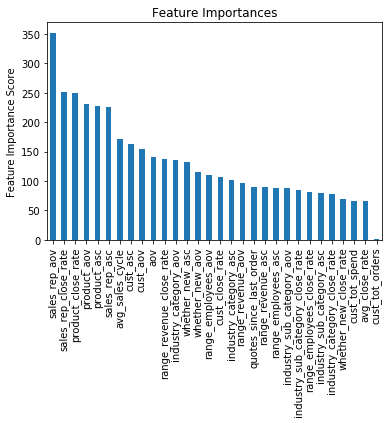

In [106]:
xgb_importance_plot(xgb2)

In [107]:
model_report(xgb2, x_test2, y_test2, name='XGB', title='2 Weeks')

XGB Testing Report for Whether Closed in 2 Weeks:
XGB accuracy: 0.9517
XGB AUC Score: 0.9789
XGB confusion matrix:
True Positive 2318
True Negative 30654
False Positive 1069
False Negative 603


In [108]:
model_report(xgb2, x_test4, y_test4, name='XGB for New Customer', title='2 Weeks')

XGB for New Customer Testing Report for Whether Closed in 2 Weeks:
XGB for New Customer accuracy: 0.9569
XGB for New Customer AUC Score: 0.9814
XGB for New Customer confusion matrix:
True Positive 2303
True Negative 29709
False Positive 1069
False Negative 372


#### Retrain XGBoost on entire data

In [109]:
# Since XGB model performs better than MLPC, it should be adopted and retrained on all data

# Prediction for whether closed in 3 days
xgb_full_3d = XGBClassifier(max_depth=5, n_estimators=200, learning_rate=0.1, reg_alpha=1, reg_lambda=3, random_state=31)
xgb_full_3d.fit(features, close_3d)
xgb_full_3d_pred = xgb_full_3d.predict(features)
xgb_full_3d_predprob = xgb_full_3d.predict_proba(features)[:,1]

# Prediction for whether closed in 3 days
xgb_full_2w = XGBClassifier(max_depth=5, n_estimators=200, learning_rate=0.1, reg_alpha=1, reg_lambda=3, random_state=31)
xgb_full_2w.fit(features, close_2w)
xgb_full_2w_pred = xgb_full_2w.predict(features)
xgb_full_2w_predprob = xgb_full_2w.predict_proba(features)[:,1]

#### Add Prediction Result to Original Data

In [110]:
df1['xgb_pred_close_3d'] = xgb_full_3d_pred
df1['xgb_pred_close_3d_prob'] = xgb_full_3d_predprob
df1['xgb_pred_close_2w'] = xgb_full_2w_pred
df1['xgb_pred_close_2w_prob'] = xgb_full_2w_predprob

In [111]:
df2 = pd.merge(df, df1[df1.columns.difference(cols)], on=list(df1.columns.difference(cols)[:-4]), how='left')
# df2.to_csv('lead_close_rate_classification.csv',encoding='utf-8')

In [112]:
# save test result for whether closed in 2 weeks on only new customers
test4 = df.iloc[x_test4.index.tolist(),:].copy()

test4['xgb_pred'] = xgb2.predict(x_test4)
test4['xgb_prob'] = xgb2.predict_proba(x_test4)[:,1]

# test4.to_csv('close_2w_new_cust_test_result.csv',encoding='utf-8')